In [22]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2.4.0
2.4.3


In [23]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5276311234083603163
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8855182400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6665042305402558684
physical_device_desc: "device: 0, name: GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [25]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import time

start = time.time()

## Load data

In [26]:
directory = "Testing_data/"
stock_data_list = []

for filename in os.listdir(directory):
    if len(filename) > 10:
        continue
    file_path = os.path.join(directory, filename)
    stock_data = pd.read_csv(file_path)
    stock_data = stock_data.rename(columns={'Data': 'Date', 'Otwarcie': 'Open', 'Najwyzszy': 'Highest', 'Najnizszy': 'Lowest', 'Zamkniecie': 'Close', 'Wolumen': 'Volume'})
    stock_data['Date'] = pd.to_datetime(stock_data.Date)
    stock_data_list.append(stock_data)
    print('Loaded file: ' + filename)

for i in range(len(stock_data_list)):
    stock_data_list[i] = stock_data_list[i].dropna()

Loaded file: acp_d.csv
Loaded file: alr_d.csv
Loaded file: ccc_d.csv
Loaded file: cdr_d.csv
Loaded file: dnp_d.csv
Loaded file: kgh_d.csv
Loaded file: pkn_d.csv


In [27]:
def get_moving_average(data, period):
    data['MA'] = data['Close'].rolling(period).mean()
    return data

In [28]:
def get_RSI (data, period):
    increase_difference, decrease_difference = data['Close'].diff(), data['Close'].diff()
    increase_difference[increase_difference < 0] = 0
    decrease_difference[decrease_difference > 0] = 0
    roll_increase = increase_difference.ewm(span = period).mean()
    roll_decrease = decrease_difference.abs().ewm(span = period).mean()
    RS = roll_increase / roll_decrease
    data['RSI'] = 100 - (100 / (1 + RS))
    return data

In [29]:
def get_ROC(data):
    data['ROC'] = data['Close'].pct_change()
    return data

In [30]:
def get_stochastic_oscillator(data, period):
    L14, H14 = data['Close'].rolling(period).min(), data['Close'].rolling(period).max()
    data['K'] = (data['Close'] - L14)/(H14 - L14)
    return data

In [31]:
def get_SO_moving_average(data, so_period, ma_period):
    L, H = data['Close'].rolling(so_period).min(), data['Close'].rolling(so_period).max()
    K = (data['Close'] - L)/(H - L)
    data['D'] = K.rolling(ma_period).mean()
    return data

In [32]:
def get_MACD(data, period_long, period_short):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    data['MACD'] = EMA_short - EMA_long
    return data

In [33]:
def get_MACD_histogram(data, period_long, period_short, period_signal):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    MACD = EMA_short - EMA_long
    MACD_signal = MACD.ewm(9).mean()
    data['MACD_Histogram'] = MACD - MACD_signal
    return data

In [34]:
def get_PPO(data, period_long, period_short):
    EMA_long = data['Close'].ewm(period_long).mean()
    EMA_short = data['Close'].ewm(period_short).mean()
    data['PPO'] = (EMA_short - EMA_long)/EMA_long
    return data

In [35]:
def get_TEMA(data, period):
    SEMA = data['Close'].ewm(period).mean()
    DEMA = SEMA.ewm(period).mean()
    data['TEMA'] = DEMA.ewm(period).mean()
    return(data)

In [36]:
def get_CGI(data, period):
    typical_price = (data['Highest'] + data['Lowest'] + data['Close']) / 3
    MA = typical_price.rolling(period).mean()
    mean_deviation = (MA - typical_price).abs().rolling(period).mean()
    data['CCI'] = (typical_price - MA) / (0.15 * mean_deviation)
    return(data)

In [37]:
def get_Williams_Percent_Range(data, period):
    data['Percent_Range'] = (data['Highest'].rolling(period).max() - data['Close']) / (data['Highest'].rolling(period).max() - data['Lowest'].rolling(period).min())
    return(data)

In [38]:
def scale_data(data):
    list_of_features = []
    for column in data.columns:
        list_of_features.append(data[column])

    dataset = np.transpose(list_of_features)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    return scaled_data, scaler

In [39]:
def scale_data_X_Y(data):
    list_of_features = []
    list_of_outputs = []
    for column in data.columns:
        list_of_features.append(data[column])
        if column in ['Open', 'Close', 'Highest', 'Lowest', 'Volume']:
            list_of_outputs.append(data[column])
        
    dataset = np.transpose(list_of_features)
    output_dataset = np.transpose(list_of_outputs)
    X_scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = X_scaler.fit_transform(dataset)
    Y_scaler = MinMaxScaler(feature_range=(0,1))
    Y_scaler.fit_transform(output_dataset)

    return scaled_data, X_scaler, Y_scaler

In [40]:
def prepare_input_and_output(data, number_of_sessions=60):
    # number_of_sessions - number of considered previous sessions as an input
    X = []
    Y = []
    for i in range(number_of_sessions, data.shape[0]):
        X.append(data[i-number_of_sessions:i, :])
        Y.append(data[i, :5])
    return X, Y

# Testing for the best technical indicators parameters

In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Checking how algorithm works without techincal indicators (learning based on prices and volume)

In [42]:
X_all = []
Y_all = []
stocks_base = []
results_base = []
# prepare data
for stock in stock_data_list:
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks_base.append(scaled_stock)
# split for training and validation
for stock in stocks_base:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)
loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_base.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_base = pd.DataFrame(results_base)

(27145, 60, 5)
(3017, 60, 5)
(27145, 5)
(3017, 5)
Epoch 1/7
849/849 [==============================] - 8s 7ms/step - loss: 0.0351 - val_loss: 5.3315e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.3388e-04 - val_loss: 4.7992e-04
Epoch 3/7
849/849 [==============================] - 3s 4ms/step - loss: 5.1515e-04 - val_loss: 4.6628e-04
Epoch 4/7
849/849 [==============================] - 3s 4ms/step - loss: 5.0103e-04 - val_loss: 4.2200e-04
Epoch 5/7
849/849 [==============================] - 4s 4ms/step - loss: 4.6916e-04 - val_loss: 4.0989e-04
Epoch 6/7
849/849 [==============================] - 4s 4ms/step - loss: 4.5998e-04 - val_loss: 4.0114e-04
Epoch 7/7
849/849 [==============================] - 4s 4ms/step - loss: 4.7222e-04 - val_loss: 3.9902e-04
Epoch 1/7
849/849 [==============================] - 5s 5ms/step - loss: 0.0115 - val_loss: 5.5792e-04
Epoch 2/7
849/849 [==============================] - 3s 4ms/step - loss: 5.6614e-04 - val_loss: 4.9681

In [43]:
results_base

,loss,val_loss
0,0.000457,0.000404


### Moving average

In [44]:
periods = [3, 5, 10, 15, 20, 30, 45, 60, 80, 100, 125, 150, 200]
X_all_MA = []
Y_all_MA = []
results_MA = []


for period in periods:
    X_all_MA = []
    Y_all_MA = []
    stocks_MA = []
    # prepare data
    for stock in stock_data_list:
        stock_MA = get_moving_average(stock, period)
        stock_MA = stock_MA.dropna()
        scaled_stock, stock_scaler = scale_data(stock_MA.drop(columns='Date'))
        stocks_MA.append(scaled_stock)
    # split for training and validation
    for stock_MA in stocks_MA:
        X, Y = prepare_input_and_output(np.array(stock_MA))
        X_all_MA = X_all_MA + X
        Y_all_MA = Y_all_MA + Y
    X_all_MA, Y_all_MA = np.array(X_all_MA), np.array(Y_all_MA)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all_MA, Y_all_MA, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MA = pd.DataFrame(results_MA)


(27133, 60, 6)
(3015, 60, 6)
(27133, 5)
(3015, 5)
Period: 3
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0063 - val_loss: 6.7696e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 6.2418e-04 - val_loss: 5.5689e-04
Epoch 3/7
848/848 [==============================] - 3s 4ms/step - loss: 5.4723e-04 - val_loss: 5.0219e-04
Epoch 4/7
848/848 [==============================] - 3s 4ms/step - loss: 5.7580e-04 - val_loss: 4.9755e-04
Epoch 5/7
848/848 [==============================] - 3s 4ms/step - loss: 4.7713e-04 - val_loss: 4.8359e-04
Epoch 6/7
848/848 [==============================] - 3s 4ms/step - loss: 5.0816e-04 - val_loss: 4.5039e-04
Epoch 7/7
848/848 [==============================] - 3s 4ms/step - loss: 4.8887e-04 - val_loss: 5.2500e-04
Epoch 1/7
848/848 [==============================] - 5s 4ms/step - loss: 0.0074 - val_loss: 5.8400e-04
Epoch 2/7
848/848 [==============================] - 3s 4ms/step - loss: 6.0318e-04 - val_lo

Epoch 6/7
846/846 [==============================] - 5s 5ms/step - loss: 4.8662e-04 - val_loss: 5.5855e-04
Epoch 7/7
846/846 [==============================] - 5s 5ms/step - loss: 4.8049e-04 - val_loss: 5.6552e-04
Epoch 1/7
846/846 [==============================] - 8s 6ms/step - loss: 0.0304 - val_loss: 7.8211e-04
Epoch 2/7
846/846 [==============================] - 5s 5ms/step - loss: 5.8207e-04 - val_loss: 6.6307e-04
Epoch 3/7
846/846 [==============================] - 5s 5ms/step - loss: 5.3830e-04 - val_loss: 6.2737e-04
Epoch 4/7
846/846 [==============================] - 5s 5ms/step - loss: 5.1444e-04 - val_loss: 6.2050e-04
Epoch 5/7
846/846 [==============================] - 5s 5ms/step - loss: 4.7507e-04 - val_loss: 6.2846e-04
Epoch 6/7
846/846 [==============================] - 5s 5ms/step - loss: 4.6146e-04 - val_loss: 5.4892e-04
Epoch 7/7
846/846 [==============================] - 5s 5ms/step - loss: 5.1086e-04 - val_loss: 5.4699e-04
(27026, 60, 6)
(3003, 60, 6)
(27026, 5)
(

Epoch 4/7
837/837 [==============================] - 5s 5ms/step - loss: 5.6798e-04 - val_loss: 4.5018e-04
Epoch 5/7
837/837 [==============================] - 5s 5ms/step - loss: 5.0162e-04 - val_loss: 5.0347e-04
Epoch 6/7
837/837 [==============================] - 5s 5ms/step - loss: 5.0637e-04 - val_loss: 4.4588e-04
Epoch 7/7
837/837 [==============================] - 4s 5ms/step - loss: 4.8050e-04 - val_loss: 4.2044e-04
Epoch 1/7
837/837 [==============================] - 8s 6ms/step - loss: 0.0204 - val_loss: 5.3746e-04
Epoch 2/7
837/837 [==============================] - 5s 5ms/step - loss: 6.3485e-04 - val_loss: 4.6878e-04
Epoch 3/7
837/837 [==============================] - 5s 5ms/step - loss: 5.2533e-04 - val_loss: 4.5876e-04
Epoch 4/7
837/837 [==============================] - 5s 5ms/step - loss: 5.5065e-04 - val_loss: 4.8217e-04
Epoch 5/7
837/837 [==============================] - 5s 5ms/step - loss: 4.9255e-04 - val_loss: 4.3277e-04
Epoch 6/7
837/837 [======================

824/824 [==============================] - 4s 5ms/step - loss: 6.1807e-04 - val_loss: 4.7027e-04
Epoch 3/7
824/824 [==============================] - 4s 5ms/step - loss: 4.9326e-04 - val_loss: 4.5733e-04
Epoch 4/7
824/824 [==============================] - 5s 6ms/step - loss: 5.0486e-04 - val_loss: 4.2603e-04
Epoch 5/7
824/824 [==============================] - 5s 5ms/step - loss: 4.8226e-04 - val_loss: 4.1747e-04
Epoch 6/7
824/824 [==============================] - 4s 5ms/step - loss: 4.6578e-04 - val_loss: 4.0309e-04
Epoch 7/7
824/824 [==============================] - 4s 5ms/step - loss: 4.7508e-04 - val_loss: 4.1442e-04
(26207, 60, 6)
(2912, 60, 6)
(26207, 5)
(2912, 5)
Period: 150
Epoch 1/7
819/819 [==============================] - 8s 6ms/step - loss: 0.0096 - val_loss: 5.8040e-04
Epoch 2/7
819/819 [==============================] - 4s 5ms/step - loss: 6.0139e-04 - val_loss: 5.2330e-04
Epoch 3/7
819/819 [==============================] - 4s 5ms/step - loss: 5.7175e-04 - val_loss: 

In [45]:
results_MA

,period,loss,val_loss
0,3,0.000474,0.000484
1,5,0.000458,0.000545
2,10,0.000452,0.000575
3,15,0.000464,0.000551
4,20,0.000443,0.000688
5,30,0.000475,0.000527
6,45,0.000465,0.000501
7,60,0.000477,0.000439
8,80,0.000468,0.000513
9,100,0.000477,0.000380


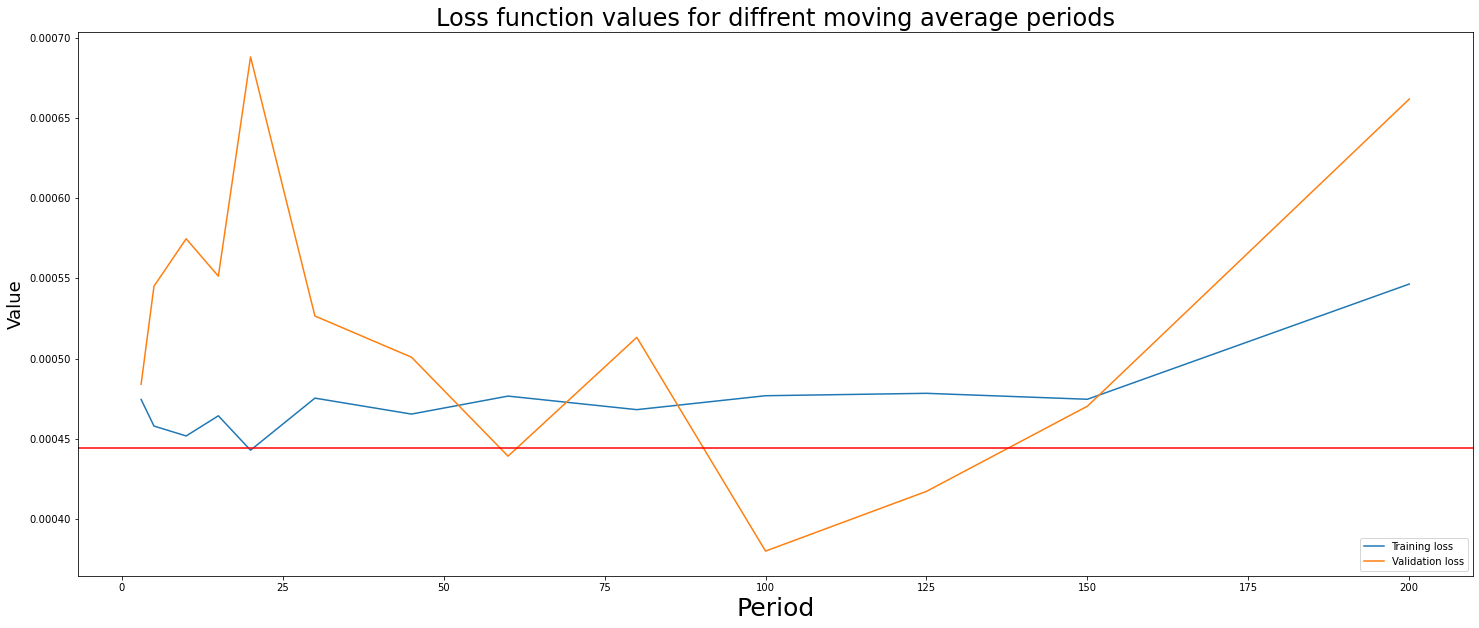

In [46]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MA['period'], results_MA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

### RSI

In [47]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_RSI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_RSI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_RSI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_RSI = pd.DataFrame(results_RSI)


(25892, 60, 7)
(2877, 60, 7)
(25892, 5)
(2877, 5)
Period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0088 - val_loss: 6.7634e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.5067e-04 - val_loss: 6.1238e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8518e-04 - val_loss: 6.3834e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3928e-04 - val_loss: 6.2972e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3752e-04 - val_loss: 5.7656e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3524e-04 - val_loss: 5.8930e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6582e-04 - val_loss: 5.6548e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0184 - val_loss: 7.7796e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.7534e-04 - val_lo

Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3025e-04 - val_loss: 6.1079e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.2832e-04 - val_loss: 5.7622e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0028 - val_loss: 5.8976e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2823e-04 - val_loss: 5.7514e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9644e-04 - val_loss: 5.7263e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7212e-04 - val_loss: 5.3505e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.4407e-04 - val_loss: 5.2547e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6248e-04 - val_loss: 5.4689e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5366e-04 - val_loss: 5.2110e-04
(25892, 60, 7)
(2877, 60, 7)
(25892, 5)
(

In [48]:
results_RSI

,period,loss,val_loss
0,3,0.000563,0.000588
1,5,0.000554,0.000636
2,7,0.000554,0.000606
3,10,0.000560,0.000551
4,14,0.000555,0.000618


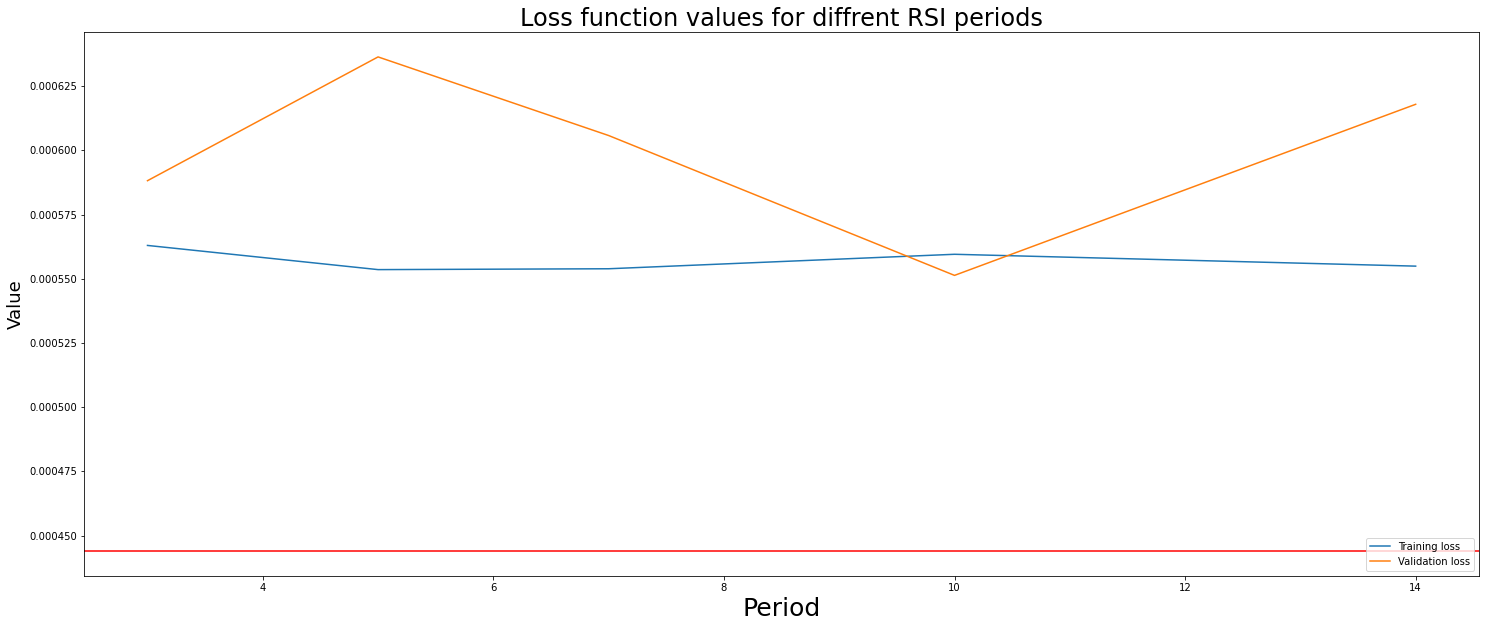

In [49]:
plt.figure(figsize=(25,10))
plt.title('Loss function values for diffrent RSI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_RSI['period'], results_RSI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## ROC

In [50]:
X_all = []
Y_all = []
results_ROC = []


X_all = []
Y_all = []
stocks = []
# prepare data
for stock in stock_data_list:
    stock = get_ROC(stock)
    stock = stock.dropna()
    scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
    stocks.append(scaled_stock)
# split for training and validation
for stock in stocks:
    X, Y = prepare_input_and_output(np.array(stock))
    X_all = X_all + X
    Y_all = Y_all + Y
X_all, Y_all = np.array(X_all), np.array(Y_all)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

loss_results = []
val_loss_results = []
for i in range(3):
    model = Sequential()
    model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(Y_train.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
    loss_results.append(history.history['loss'][-1])
    val_loss_results.append(history.history['val_loss'][-1])
results_ROC.append({'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_ROC = pd.DataFrame(results_ROC)

(25892, 60, 8)
(2877, 60, 8)
(25892, 5)
(2877, 5)
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0158 - val_loss: 7.0248e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.3988e-04 - val_loss: 6.7588e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8802e-04 - val_loss: 6.2202e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6212e-04 - val_loss: 6.1795e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7013e-04 - val_loss: 6.2997e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.5475e-04 - val_loss: 6.0680e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.3258e-04 - val_loss: 5.8303e-04
Epoch 1/7
810/810 [==============================] - 4s 4ms/step - loss: 0.0146 - val_loss: 8.2114e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8165e-04 - val_loss: 6.5626

In [51]:
results_ROC

,loss,val_loss
0,0.000548,0.000594


## Stochastic oscillator

In [52]:
periods = [3, 5, 7, 10, 14]
X_all = []
Y_all = []
results_SO = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_stochastic_oscillator(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_SO.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO = pd.DataFrame(results_SO)


(25738, 60, 9)
(2860, 60, 9)
(25738, 5)
(2860, 5)
Period: 3
Epoch 1/7
805/805 [==============================] - 5s 4ms/step - loss: 0.0060 - val_loss: 6.0809e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 6.1896e-04 - val_loss: 6.3109e-04
Epoch 3/7
805/805 [==============================] - 3s 4ms/step - loss: 5.9583e-04 - val_loss: 5.7728e-04
Epoch 4/7
805/805 [==============================] - 3s 4ms/step - loss: 5.3823e-04 - val_loss: 5.6334e-04
Epoch 5/7
805/805 [==============================] - 3s 4ms/step - loss: 5.6826e-04 - val_loss: 5.8957e-04
Epoch 6/7
805/805 [==============================] - 3s 4ms/step - loss: 5.7560e-04 - val_loss: 5.3783e-04
Epoch 7/7
805/805 [==============================] - 3s 4ms/step - loss: 5.5888e-04 - val_loss: 5.4533e-04
Epoch 1/7
805/805 [==============================] - 5s 4ms/step - loss: 0.0180 - val_loss: 8.3845e-04
Epoch 2/7
805/805 [==============================] - 3s 4ms/step - loss: 6.6854e-04 - val_lo

Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8083e-04 - val_loss: 5.3894e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6164e-04 - val_loss: 6.0884e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0201 - val_loss: 0.0010
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 9.3952e-04 - val_loss: 6.8112e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 6.6171e-04 - val_loss: 6.0515e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.6734e-04 - val_loss: 5.6099e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1750e-04 - val_loss: 5.4795e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8720e-04 - val_loss: 5.6724e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0273e-04 - val_loss: 5.4207e-04
(25892, 60, 9)
(2877, 60, 9)
(25892, 5)
(2877

In [53]:
results_SO

,period,loss,val_loss
0,3,0.000561,0.000569
1,5,0.000546,0.000577
2,7,0.000542,0.000635
3,10,0.000563,0.000571
4,14,0.000568,0.000493


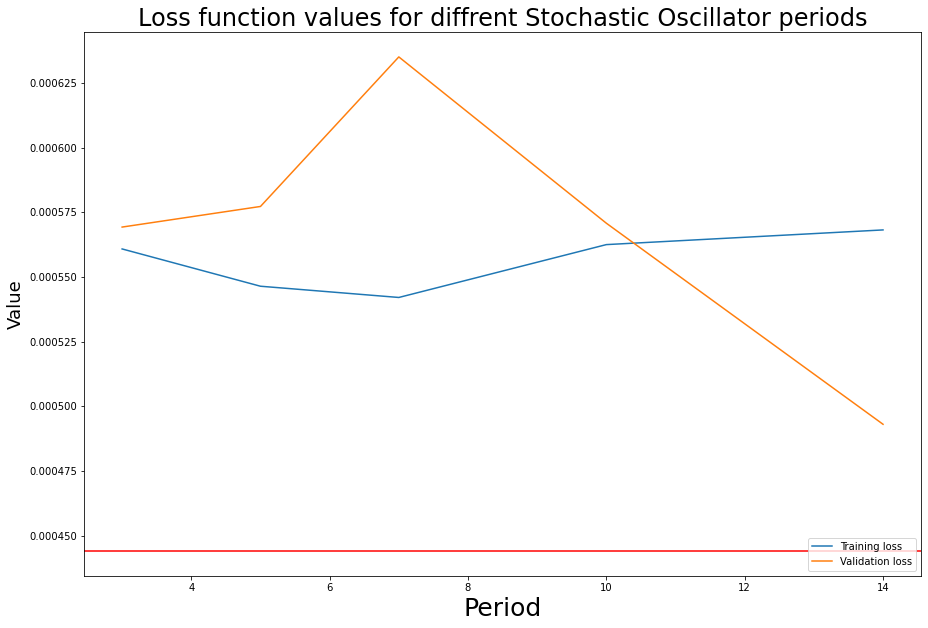

In [54]:
plt.figure(figsize=(15,10))
plt.title('Loss function values for diffrent Stochastic Oscillator periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_SO['period'], results_SO[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Moving average of stochastic oscillator

In [ ]:
so_periods = [3, 5, 7, 10, 14]
ma_periods = [2, 3, 4, 5, 6]
X_all = []
Y_all = []
results_SO_MA = []


for so_period in so_periods:
    for ma_period in ma_periods:
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_SO_moving_average(stock, so_period, ma_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Stochastic Oscillator period: ' + str(so_period))
        print('Moving average period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_SO_MA.append({'so_period': so_period, 'ma_period': ma_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_SO_MA = pd.DataFrame(results_SO_MA)


(25615, 60, 10)
(2847, 60, 10)
(25615, 5)
(2847, 5)
Stochastic Oscillator period: 3
Moving average period: 2
Epoch 1/7
801/801 [==============================] - 5s 4ms/step - loss: 0.0251 - val_loss: 6.4069e-04
Epoch 2/7
801/801 [==============================] - 3s 4ms/step - loss: 6.4333e-04 - val_loss: 5.9190e-04
Epoch 3/7
801/801 [==============================] - 3s 4ms/step - loss: 6.0058e-04 - val_loss: 5.8102e-04
Epoch 4/7
801/801 [==============================] - 3s 4ms/step - loss: 5.9845e-04 - val_loss: 5.7969e-04
Epoch 5/7
801/801 [==============================] - 3s 4ms/step - loss: 5.5011e-04 - val_loss: 5.6712e-04
Epoch 6/7
801/801 [==============================] - 3s 4ms/step - loss: 6.0765e-04 - val_loss: 5.5925e-04
Epoch 7/7
801/801 [==============================] - 3s 4ms/step - loss: 5.6000e-04 - val_loss: 5.8002e-04
Epoch 1/7
801/801 [==============================] - 5s 4ms/step - loss: 0.0111 - val_loss: 8.3359e-04
Epoch 2/7
801/801 [========================

Epoch 4/7
790/790 [==============================] - 3s 4ms/step - loss: 6.1004e-04 - val_loss: 5.4160e-04
Epoch 5/7
790/790 [==============================] - 3s 4ms/step - loss: 6.0202e-04 - val_loss: 4.8936e-04
Epoch 6/7
790/790 [==============================] - 3s 4ms/step - loss: 5.5899e-04 - val_loss: 4.8923e-04
Epoch 7/7
790/790 [==============================] - 3s 4ms/step - loss: 5.3696e-04 - val_loss: 5.1412e-04
Epoch 1/7
790/790 [==============================] - 5s 4ms/step - loss: 0.0138 - val_loss: 7.5638e-04
Epoch 2/7
790/790 [==============================] - 3s 4ms/step - loss: 7.2871e-04 - val_loss: 5.6566e-04
Epoch 3/7
790/790 [==============================] - 3s 4ms/step - loss: 6.2617e-04 - val_loss: 5.4342e-04
Epoch 4/7
790/790 [==============================] - 3s 4ms/step - loss: 6.4542e-04 - val_loss: 5.1937e-04
Epoch 5/7
790/790 [==============================] - 3s 4ms/step - loss: 6.1601e-04 - val_loss: 4.9958e-04
Epoch 6/7
790/790 [======================

(25866, 60, 10)
(2874, 60, 10)
(25866, 5)
(2874, 5)
Stochastic Oscillator period: 5
Moving average period: 4
Epoch 1/7
809/809 [==============================] - 5s 4ms/step - loss: 0.0088 - val_loss: 7.1569e-04
Epoch 2/7
809/809 [==============================] - 3s 4ms/step - loss: 6.8376e-04 - val_loss: 5.8050e-04
Epoch 3/7
809/809 [==============================] - 3s 4ms/step - loss: 6.0648e-04 - val_loss: 6.0809e-04
Epoch 4/7
809/809 [==============================] - 3s 4ms/step - loss: 6.2331e-04 - val_loss: 5.3245e-04
Epoch 5/7
809/809 [==============================] - 3s 4ms/step - loss: 5.6842e-04 - val_loss: 5.1846e-04
Epoch 6/7
809/809 [==============================] - 3s 4ms/step - loss: 5.7034e-04 - val_loss: 5.2613e-04
Epoch 7/7
809/809 [==============================] - 3s 4ms/step - loss: 5.7377e-04 - val_loss: 5.1893e-04
Epoch 1/7
809/809 [==============================] - 5s 4ms/step - loss: 0.0217 - val_loss: 6.1907e-04
Epoch 2/7
809/809 [========================

809/809 [==============================] - 3s 3ms/step - loss: 5.9408e-04 - val_loss: 5.3989e-04
Epoch 5/7
809/809 [==============================] - 3s 3ms/step - loss: 5.6008e-04 - val_loss: 5.4033e-04
Epoch 6/7
809/809 [==============================] - 3s 3ms/step - loss: 5.5954e-04 - val_loss: 5.5607e-04
Epoch 7/7
809/809 [==============================] - 3s 3ms/step - loss: 5.6314e-04 - val_loss: 5.3526e-04
Epoch 1/7
809/809 [==============================] - 4s 4ms/step - loss: 0.0100 - val_loss: 6.5825e-04
Epoch 2/7
809/809 [==============================] - 3s 3ms/step - loss: 6.6076e-04 - val_loss: 6.3735e-04
Epoch 3/7
809/809 [==============================] - 3s 3ms/step - loss: 5.9320e-04 - val_loss: 6.1141e-04
Epoch 4/7
809/809 [==============================] - 3s 3ms/step - loss: 5.9583e-04 - val_loss: 5.4807e-04
Epoch 5/7
809/809 [==============================] - 3s 3ms/step - loss: 5.4965e-04 - val_loss: 5.4582e-04
Epoch 6/7
809/809 [==============================] 

(25884, 60, 10)
(2877, 60, 10)
(25884, 5)
(2877, 5)
Stochastic Oscillator period: 7
Moving average period: 6
Epoch 1/7
809/809 [==============================] - 5s 4ms/step - loss: 0.0105 - val_loss: 7.4607e-04
Epoch 2/7
809/809 [==============================] - 3s 4ms/step - loss: 6.7130e-04 - val_loss: 7.7337e-04
Epoch 3/7
809/809 [==============================] - 3s 4ms/step - loss: 6.2800e-04 - val_loss: 6.5413e-04
Epoch 4/7
809/809 [==============================] - 3s 4ms/step - loss: 5.9721e-04 - val_loss: 6.7232e-04
Epoch 5/7
809/809 [==============================] - 3s 4ms/step - loss: 5.8177e-04 - val_loss: 6.2405e-04
Epoch 6/7
809/809 [==============================] - 3s 4ms/step - loss: 5.9377e-04 - val_loss: 6.5248e-04
Epoch 7/7
809/809 [==============================] - 3s 4ms/step - loss: 5.6682e-04 - val_loss: 6.2687e-04
Epoch 1/7
809/809 [==============================] - 5s 4ms/step - loss: 0.0130 - val_loss: 7.7954e-04
Epoch 2/7
809/809 [========================

Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.0153e-04 - val_loss: 4.4966e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 6.1346e-04 - val_loss: 4.0365e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6084e-04 - val_loss: 4.3605e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6787e-04 - val_loss: 4.2346e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0176 - val_loss: 4.7306e-04
Epoch 2/7
810/810 [==============================] - 3s 4ms/step - loss: 6.6481e-04 - val_loss: 4.3494e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8147e-04 - val_loss: 4.9503e-04
Epoch 4/7
810/810 [==============================] - 3s 4ms/step - loss: 6.2873e-04 - val_loss: 4.1883e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.9192e-04 - val_loss: 4.1280e-04
Epoch 6/7
810/810 [======================

(25892, 60, 10)
(2877, 60, 10)
(25892, 5)
(2877, 5)
Stochastic Oscillator period: 14
Moving average period: 3
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0301 - val_loss: 6.3037e-04
Epoch 2/7
810/810 [==============================] - 4s 4ms/step - loss: 6.5926e-04 - val_loss: 5.3420e-04
Epoch 3/7
810/810 [==============================] - 3s 4ms/step - loss: 5.8963e-04 - val_loss: 5.1049e-04
Epoch 4/7
810/810 [==============================] - 4s 4ms/step - loss: 5.8386e-04 - val_loss: 5.1955e-04
Epoch 5/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6805e-04 - val_loss: 5.5603e-04
Epoch 6/7
810/810 [==============================] - 3s 4ms/step - loss: 5.7876e-04 - val_loss: 5.1218e-04
Epoch 7/7
810/810 [==============================] - 3s 4ms/step - loss: 5.6498e-04 - val_loss: 4.7937e-04
Epoch 1/7
810/810 [==============================] - 5s 4ms/step - loss: 0.0148 - val_loss: 6.9124e-04
Epoch 2/7
810/810 [=======================

In [ ]:
results_SO_MA

In [ ]:
fig, axes = plt.subplots(len(results_SO_MA['so_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods for  Moving average of Stochastic Oscillator', size=24)

axes_counter = 0
for so_period in results_SO_MA['so_period'].unique():
    axes[axes_counter].title.set_text('Stochastic Oscillator period = ' + str(so_period))
    axes[axes_counter].plot(results_SO_MA['ma_period'].where(results_SO_MA['so_period']==so_period), results_SO_MA[['loss', 'val_loss']].where(results_SO_MA['so_period']==so_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

## MACD

In [ ]:
long_periods = [10, 18, 26]
short_periods = [6, 9, 12]
X_all = []
Y_all = []
results_MACD = []


for long_period in long_periods:
    for short_period in short_periods:
        if long_period <= short_period:
            continue
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_MACD(stock, long_period, short_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Long period: ' + str(so_period))
        print('Short period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_MACD.append({'long_period': long_period, 'short_period': short_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD = pd.DataFrame(results_MACD)

In [ ]:
results_MACD

In [ ]:
fig, axes = plt.subplots(len(results_MACD['long_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods of MACD', size=24)

axes_counter = 0
for long_period in results_MACD['long_period'].unique():
    axes[axes_counter].title.set_text('MACD long period = ' + str(long_period))
    axes[axes_counter].plot(results_MACD['short_period'].where(results_MACD['long_period']==long_period), results_MACD[['loss', 'val_loss']].where(results_MACD['long_period']==long_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

## MACD Histogram for diffrent signal lines

In [ ]:
long_period = 26
short_period = 12
signal_periods = [3, 5, 9, 12]

X_all = []
Y_all = []
results_MACD_histogram = []


for signal_period in signal_periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_MACD_histogram(stock, long_period, short_period, signal_period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('Signal line period: ' + str(signal_period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_MACD_histogram.append({'long_period': long_period,'short_period': short_period,'signal_period': signal_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_MACD_histogram = pd.DataFrame(results_MACD_histogram)


In [ ]:
results_MACD_histogram

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent MACD signal line periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_MACD_histogram['signal_period'], results_MACD_histogram[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.show()

## Price Oscillator PPO

In [ ]:
long_periods = [10, 18, 26]
short_periods = [6, 9, 12]
X_all = []
Y_all = []
results_PPO = []


for long_period in long_periods:
    for short_period in short_periods:
        if long_period <= short_period:
            continue
        X_all = []
        Y_all = []
        stocks = []
        # prepare data
        for stock in stock_data_list:
            stock = get_PPO(stock, long_period, short_period)
            stock = stock.dropna()
            scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
            stocks.append(scaled_stock)
        # split for training and validation
        for stock in stocks:
            X, Y = prepare_input_and_output(np.array(stock))
            X_all = X_all + X
            Y_all = Y_all + Y
        X_all, Y_all = np.array(X_all), np.array(Y_all)
        X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
        print(X_train.shape)
        print(X_valid.shape)
        print(Y_train.shape)
        print(Y_valid.shape)
        #
        print('Long period: ' + str(so_period))
        print('Short period: ' + str(ma_period))
        loss_results = []
        val_loss_results = []
        for i in range(3):
            model = Sequential()
            model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(Y_train.shape[1]))
            model.compile(loss='mse', optimizer='adam')
            history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
            loss_results.append(history.history['loss'][-1])
            val_loss_results.append(history.history['val_loss'][-1])
        results_PPO.append({'long_period': long_period, 'short_period': short_period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_PPO = pd.DataFrame(results_PPO)

In [ ]:
results_PPO

In [ ]:
fig, axes = plt.subplots(len(results_PPO['long_period'].unique()))
fig.set_size_inches(10,10)
fig.suptitle('Loss function values for diffrent perdiods of PPO', size=24)

axes_counter = 0
for long_period in results_PPO['long_period'].unique():
    axes[axes_counter].title.set_text('PPO long period = ' + str(long_period))
    axes[axes_counter].plot(results_PPO['short_period'].where(results_PPO['long_period']==long_period), results_PPO[['loss', 'val_loss']].where(results_PPO['long_period']==long_period))
    axes[axes_counter].legend(['Training loss',  'Validation loss'])
    axes_counter += 1

## Triple exponential moving average TEMA

In [ ]:
periods = [3, 5, 9, 12, 15, 21]

X_all = []
Y_all = []
results_TEMA = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_TEMA(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('TEMA period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_TEMA.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_TEMA = pd.DataFrame(results_TEMA)


In [ ]:
results_TEMA

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent triple exponential moving average periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_TEMA['period'], results_TEMA[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Commodity Channel  Index CGI

In [ ]:
periods = [5, 10, 15, 20]

X_all = []
Y_all = []
results_CGI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_CGI(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('CGI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_CGI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_CGI = pd.DataFrame(results_CGI)


In [ ]:
results_CGI

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent CGI periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_CGI['period'], results_CGI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

## Williams Percent Range WPI

In [ ]:
periods = [5, 7, 10, 14, 21]

X_all = []
Y_all = []
results_WPI = []


for period in periods:
    X_all = []
    Y_all = []
    stocks = []
    # prepare data
    for stock in stock_data_list:
        stock = get_Williams_Percent_Range(stock, period)
        stock = stock.dropna()
        scaled_stock, stock_scaler = scale_data(stock.drop(columns='Date'))
        stocks.append(scaled_stock)
    # split for training and validation
    for stock in stocks:
        X, Y = prepare_input_and_output(np.array(stock))
        X_all = X_all + X
        Y_all = Y_all + Y
    X_all, Y_all = np.array(X_all), np.array(Y_all)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size=0.1, shuffle=True)
    print(X_train.shape)
    print(X_valid.shape)
    print(Y_train.shape)
    print(Y_valid.shape)
    #
    print('WPI period: ' + str(period))
    loss_results = []
    val_loss_results = []
    for i in range(3):
        model = Sequential()
        model.add(LSTM(32, input_shape=[X_train.shape[1], X_train.shape[2]]))
        model.add(Dense(10, activation='relu'))
        model.add(Dense(Y_train.shape[1]))
        model.compile(loss='mse', optimizer='adam')
        history = model.fit(X_train, Y_train, epochs=7, validation_data=(X_valid, Y_valid))
        loss_results.append(history.history['loss'][-1])
        val_loss_results.append(history.history['val_loss'][-1])
    results_WPI.append({'period': period, 'loss': np.mean(loss_results), 'val_loss': np.mean(val_loss_results)})
results_WPI = pd.DataFrame(results_WPI)


In [ ]:
results_WPI

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Loss function values for diffrent Williams Percent Range periods', fontsize=24)
plt.xlabel('Period', fontsize=25)
plt.ylabel('Value', fontsize=18)
plt.plot(results_WPI['period'], results_WPI[['loss', 'val_loss']])
plt.legend(['Training loss',  'Validation loss'], loc='lower right')
plt.axhline(0.000444, color='r', label = 'Loss without indicator')
plt.show()

In [ ]:
end = time.time()
print('Time of executing the script: ' + str(round((end - start)/3600, 2)) + 'h')